[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/nsga2_spea2.ipynb)

# Optimizing multiple objectives with NSGA2 & SPEA2 in Jax

This notebook shows how to use QDax to find diverse and performing parameters on a multi-objectives Rastrigin problem, using [NSGA2](https://ieeexplore.ieee.org/document/996017) and [SPEA2](https://www.semanticscholar.org/paper/SPEA2%3A-Improving-the-strength-pareto-evolutionary-Zitzler-Laumanns/b13724cb54ae4171916f3f969d304b9e9752a57f) algorithms. It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter instance
- how to create an NSGA2 instance
- how to create an SPEA2 instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [2]:
pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.3/639.3 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qdax 0.2.3 requires 

In [3]:
import jax.numpy as jnp
import jax

from typing import Tuple

import matplotlib.pyplot as plt

from functools import partial

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex

try:
    import jumanji
except:
    !pip install "jumanji==0.2.2"
    import jumanji

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.baselines.nsga2 import (
    NSGA2
)
from qdax.baselines.spea2 import (
    SPEA2
)

from qdax.core.emitters.mutation_operators import (
    polynomial_crossover,
    polynomial_mutation
)
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.pareto_front import compute_pareto_front
from qdax.utils.plotting import plot_global_pareto_front

from qdax.utils.pareto_front import compute_pareto_front
from qdax.utils.plotting import plot_global_pareto_front
from qdax.utils.metrics import default_ga_metrics

from qdax.types import Genotype, Fitness, Descriptor

/usr/local/lib/python3.10/dist-packages/trimesh/curvature.py:12: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is deprecated.
  from scipy.sparse.coo import coo_matrix


## Set the hyperparameters

In [78]:
#@markdown ---
population_size = 1000 #@param {type:"integer"}
num_iterations = 1000 #@param {type:"integer"}
proportion_mutation = 0.5 #@param {type:"number"}
minval = -4 #@param {type:"number"}
maxval = 4 #@param {type:"number"}
batch_size = 100 #@param {type:"integer"}
genotype_dim = 4 #@param {type:"integer"}
lag = 2.2 #@param {type:"number"}
base_lag = 0 #@param {type:"number"}
# for spea2
num_neighbours=1 #@param {type:"integer"}
#@markdown ---

# min/max = 5.12

## Define the scoring function: rastrigin multi-objective

We use two rastrigin functions with an offset to create a multi-objective problem.

In [79]:
# def rastrigin_scorer(
#     genotypes: jnp.ndarray, base_lag: float, lag: float
# ) -> Tuple[Fitness, Descriptor]:
#     """
#     Rastrigin Scorer with first two dimensions as descriptors
#     """
#     descriptors = genotypes[:, :2]
#     f1 = -(
#         10 * genotypes.shape[1]
#         + jnp.sum(
#             (genotypes - base_lag) ** 2
#             - 10 * jnp.cos(2 * jnp.pi * (genotypes - base_lag)),
#             axis=1,
#         )
#     )

#     f2 = -(
#         10 * genotypes.shape[1]
#         + jnp.sum(
#             (genotypes - lag) ** 2 - 10 * jnp.cos(2 * jnp.pi * (genotypes - lag)),
#             axis=1,
#         )
#     )
#     scores = jnp.stack([f1, f2], axis=-1)

#     return scores, descriptors

In [80]:
# # Scoring function
# scoring_function = partial(
#     rastrigin_scorer,
#     lag=lag,
#     base_lag=base_lag
# )

# def scoring_fn(x, random_key):
#     return scoring_function(x)[0], {}, random_key

In [81]:
def fonseca_fleming_scorer(
    genotypes: jnp.ndarray, genotype_dim: float
) -> Tuple[Fitness, Descriptor]:
    """
    Fonseca–Fleming function Scorer with first two dimensions as descriptors
    """


    f1 = (1 - jnp.exp(- jnp.sum( (genotypes  - jnp.sqrt(1/genotype_dim))**2 , axis = 1 )) )

    f2 = (1 - jnp.exp(- jnp.sum( (genotypes  + jnp.sqrt(1/genotype_dim))**2 , axis = 1)))

    descriptors = genotypes[:, :2]

    scores = jnp.stack([f1, f2], axis=-1)


    return scores, descriptors

In [82]:
# Scoring function
scoring_function = partial(fonseca_fleming_scorer, genotype_dim= genotype_dim)
    #, #rastrigin_scorer,
    #lag=lag,
    #base_lag=base_lag
#)

def scoring_fn(x, random_key):
    return scoring_function(x)[0], {}, random_key

In [83]:
# init_genotypes.shape

## Define initial population and emitter

In [84]:
# Initial population
random_key = jax.random.PRNGKey(0)
random_key, subkey = jax.random.split(random_key)
init_genotypes = jax.random.uniform(
    subkey, (batch_size, genotype_dim), minval=minval, maxval=maxval, dtype=jnp.float32
)

# Mutation & Crossover
crossover_function = partial(
    polynomial_crossover,
    proportion_var_to_change=0.25,
)

mutation_function = partial(
    polynomial_mutation,
    proportion_to_mutate=0.5,
    eta=0.05,
    minval=minval,
    maxval=maxval
)

# Define the emitter
mixing_emitter = MixingEmitter(
    mutation_fn=mutation_function,
    variation_fn=crossover_function,
    variation_percentage=1-proportion_mutation,
    batch_size=batch_size
)

## Instantiate and init NSGA2

In [85]:
# instantitiate nsga2
nsga2 = NSGA2(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=default_ga_metrics
)

# init nsga2
repertoire, emitter_state, random_key = nsga2.init(
    init_genotypes,
    population_size,
    random_key
)

## Run and visualize result

In [86]:
%%time

# run optimization loop
(repertoire, emitter_state, random_key), _ = jax.lax.scan(
    nsga2.scan_update, (repertoire, emitter_state, random_key), (), length=num_iterations
)

CPU times: user 31.1 s, sys: 152 ms, total: 31.3 s
Wall time: 24.9 s


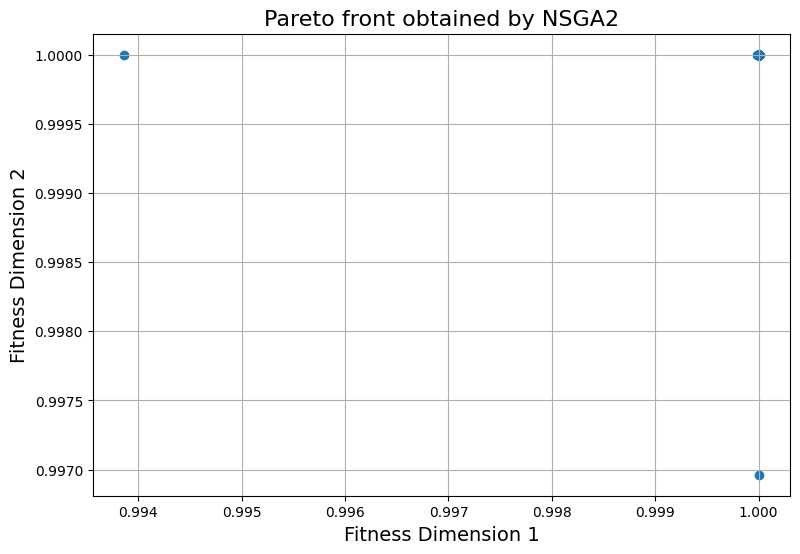

In [87]:
fig, ax = plt.subplots(figsize=(9, 6))
pareto_bool = compute_pareto_front(repertoire.fitnesses)
plot_global_pareto_front(repertoire.fitnesses[pareto_bool], ax=ax)
ax.set_title("Pareto front obtained by NSGA2", fontsize=16)
ax.set_xlabel("Fitness Dimension 1", fontsize=14)
ax.set_ylabel("Fitness Dimension 2", fontsize=14)
plt.grid()
plt.show()

## Instantiate and init SPEA2

In [64]:
# instantitiate spea2
spea2 = SPEA2(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=default_ga_metrics
)

# init spea2
repertoire, emitter_state, random_key = spea2.init(
    init_genotypes,
    population_size,
    num_neighbours,
    random_key
)

In [65]:
%%time

# run optimization loop
(repertoire, emitter_state, random_key), _ = jax.lax.scan(
    spea2.scan_update, (repertoire, emitter_state, random_key), (), length=num_iterations
)

CPU times: user 2min 50s, sys: 220 ms, total: 2min 50s
Wall time: 2min 44s


## Run and visualize result

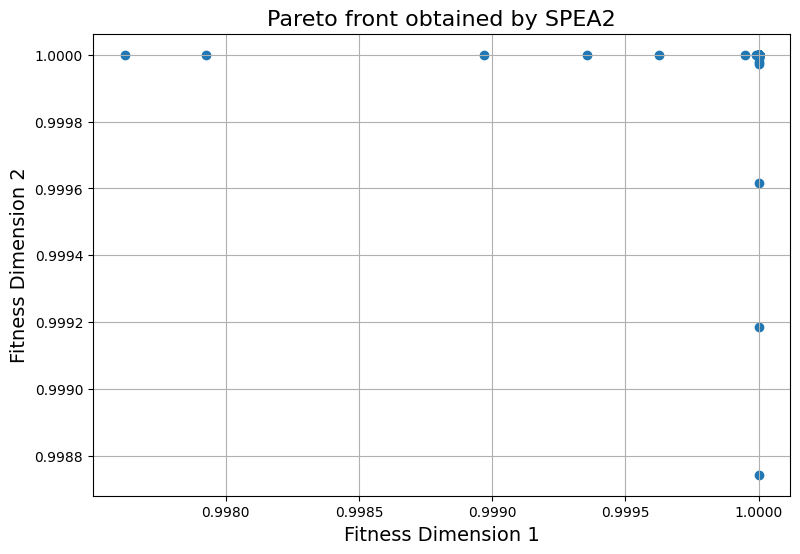

In [66]:
fig, ax = plt.subplots(figsize=(9, 6))
pareto_bool = compute_pareto_front(repertoire.fitnesses)
plot_global_pareto_front(repertoire.fitnesses[pareto_bool], ax=ax)
ax.set_title("Pareto front obtained by SPEA2", fontsize=16)
ax.set_xlabel("Fitness Dimension 1", fontsize=14)
ax.set_ylabel("Fitness Dimension 2", fontsize=14)
plt.grid()
plt.show()